# Cars

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
tsensor.__version__

'0.1b7'

In [3]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
def show(m, b, X=df_cars.WGT, Y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, Y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    # ax.set_xlim(500,1000)
    # ax.set_ylim(0,2100)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

## Brute force linear model

In [5]:
# brute force model parameter space search (m,b)
best = (1e100,0,0)
for m in np.linspace(-0.005,-.01,num=5):
    for b in np.linspace(42,47,num=5):
        y = m * df_cars.WGT + b
        mse = np.mean((y - df_cars.MPG)**2)
        if mse < best[0]:
            best = (mse,m,b)
        print(f"{m:4.3f},{b:4.3f} => MSE {mse:.1f}")
m = best[1]
b = best[2]
print(f"BEST {m:.3f}*x + {b:.3f}")

-0.005,42.000 => MSE 37.2
-0.005,43.250 => MSE 47.9
-0.005,44.500 => MSE 61.7
-0.005,45.750 => MSE 78.7
-0.005,47.000 => MSE 98.8
-0.006,42.000 => MSE 20.1
-0.006,43.250 => MSE 21.5
-0.006,44.500 => MSE 26.1
-0.006,45.750 => MSE 33.7
-0.006,47.000 => MSE 44.5
-0.007,42.000 => MSE 33.0
-0.007,43.250 => MSE 25.1
-0.007,44.500 => MSE 20.3
-0.007,45.750 => MSE 18.7
-0.007,47.000 => MSE 20.2
-0.009,42.000 => MSE 75.8
-0.009,43.250 => MSE 58.6
-0.009,44.500 => MSE 44.5
-0.009,45.750 => MSE 33.6
-0.009,47.000 => MSE 25.8
-0.010,42.000 => MSE 148.6
-0.010,43.250 => MSE 122.1
-0.010,44.500 => MSE 98.7
-0.010,45.750 => MSE 78.5
-0.010,47.000 => MSE 61.4
BEST -0.007*x + 45.750


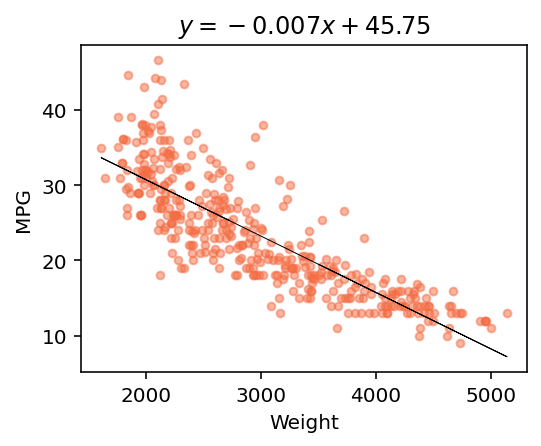

In [6]:
show(m, b)

## Linear model with numpy, one learning rate

### Manual gradient computation of loss function

use the sum, ignoring 1/n constant.

$$
loss = \sum_i^n E^2 \text{ where } E = \hat{y} - y = mx + b - y
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial m} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial m}\\
 & = & \sum_i^n E x\\
\end{array}
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial b} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial b}\\
 & = & \sum_i^n E\\
\end{array}
$$

Loss function is a saddle like this:

<img src="images/2d-loss.png" width="400">

Epoch     0 0.39,45.00: MSE loss  1530343.974 MAE  1189.63
Epoch    10 -0.01,45.00: MSE loss       18.788 MAE     3.26
LAST        -0.01,45.00: MSE loss       18.788 MAE     3.26


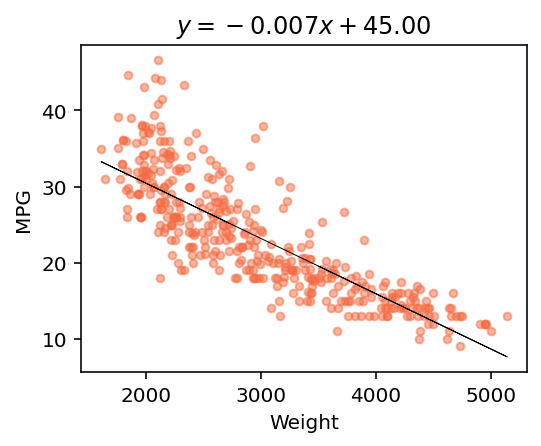

In [7]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
Y = np.array(df_cars.MPG).reshape(n,1)

# Randomly initialize weights
m = np.random.random(size=1)[0]
b = 45.0 # get it very close to an answer
learning_rate = .0000000003
nepochs=10
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - Y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - Y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b)

## Linear model with standardized/normalized variables

Standardizing variables to be mean centered and with standard deviation one, improves convergence speed. Previously we had to choose a `b` that was very close to the answer.

0.026003347977916924 0.42033543985490873
Epoch     0 0.03,0.42: MSE loss      591.278 MAE    23.03
Epoch    10 -5.75,20.85: MSE loss       25.971 MAE     3.70
Epoch    20 -6.40,23.15: MSE loss       18.770 MAE     3.26
Epoch    30 -6.48,23.41: MSE loss       18.678 MAE     3.28
Epoch    40 -6.49,23.44: MSE loss       18.677 MAE     3.28
Epoch    50 -6.49,23.45: MSE loss       18.677 MAE     3.28
LAST        -6.49,23.45: MSE loss       18.677 MAE     3.28


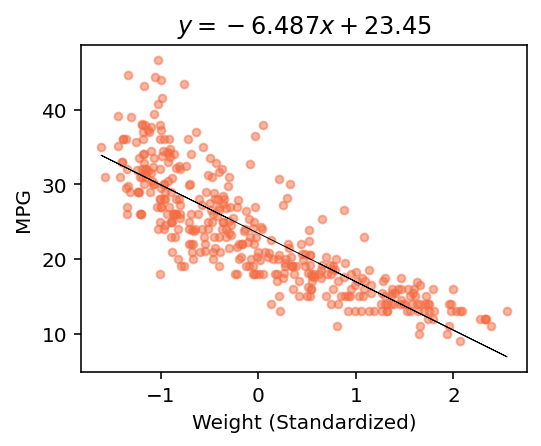

In [8]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
Y = np.array(df_cars.MPG).reshape(n,1)

X = StandardScaler().fit_transform(X)

# Randomly initialize weights
m = np.random.random(size=1)[0]
b = np.random.random(size=1)[0]
print(m,b)
learning_rate = .0005 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=50
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - Y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - Y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b, X=X, Y=df_cars.MPG)

## Linear model with pytorch

Epoch     0 -0.09,0.05: MSE loss      607.043 MAE    23.40
Epoch    10 -5.80,20.93: MSE loss       25.460 MAE     3.66
Epoch    20 -6.41,23.18: MSE loss       18.755 MAE     3.26
Epoch    30 -6.48,23.42: MSE loss       18.678 MAE     3.28
LAST        -6.48,23.42: MSE loss       18.678 MAE     3.28


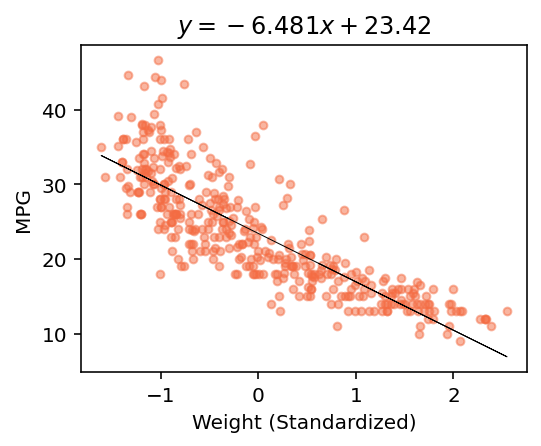

In [9]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1)
Y = torch.tensor(df_cars.MPG).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X))

# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True) # too far away from correct answer for one learning rate
learning_rate = .1 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=30
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
#     print(m.detach().item(), b.detach().item())
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b, X=X, Y=df_cars.MPG)

## Linear model with pytorch using Adam optimizer

Epoch     0 1.33,0.13: MSE loss      623.464 MAE    23.32
Epoch    10 -9.78,18.97: MSE loss       49.543 MAE     5.61
Epoch    20 -4.54,28.82: MSE loss       51.377 MAE     6.40
Epoch    30 -7.52,26.25: MSE loss       27.620 MAE     4.30
Epoch    40 -5.94,21.86: MSE loss       21.482 MAE     3.37
Epoch    50 -6.82,22.35: MSE loss       19.984 MAE     3.39
Epoch    60 -6.27,24.09: MSE loss       19.139 MAE     3.38
Epoch    70 -6.64,23.74: MSE loss       18.786 MAE     3.32
LAST       -6.64,23.65: MSE loss       18.786 MAE     3.32


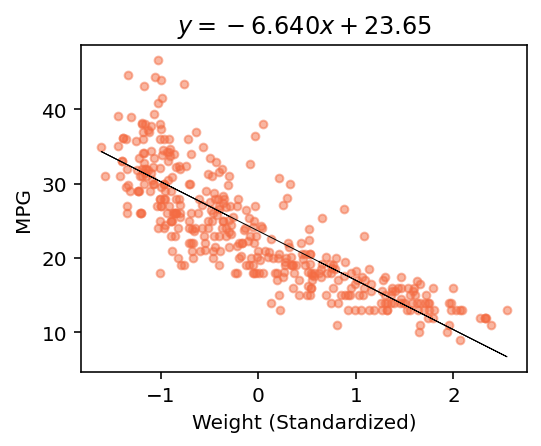

In [10]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1)
Y = torch.tensor(df_cars.MPG).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X))

# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True)

learning_rate = 2
optimizer = torch.optim.Adam([m,b], lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
m = m.detach().item()
b = b.detach().item()
print(f"LAST       {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

show(m, b, X=X, Y=df_cars.MPG)

## Built-in Linear model with pytorch

Epoch   0 MSE loss      648.299 MAE    24.38
Epoch  10 MSE loss      234.449 MAE    14.56
Epoch  20 MSE loss       54.766 MAE     6.18
Epoch  30 MSE loss       19.423 MAE     3.28
Epoch  40 MSE loss       23.631 MAE     3.94
Epoch  50 MSE loss       22.110 MAE     3.79
Epoch  60 MSE loss       19.040 MAE     3.37
Epoch  70 MSE loss       18.746 MAE     3.28
LAST      MSE loss       18.746 MAE     3.28


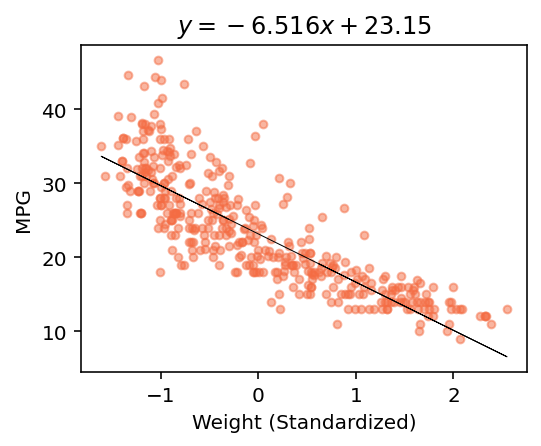

In [32]:
dtype=torch.float
n = len(df_cars)
X = torch.tensor(df_cars.WGT, dtype=dtype).reshape(n,1)
Y = torch.tensor(df_cars.MPG, dtype=dtype).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X), dtype=dtype)

model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

show(m, b, X=X, Y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

In [126]:
def show(model, X=df_cars.WGT, Y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, Y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, model(X), lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

Epoch   0 MSE loss      631.323 MAE    23.89
Epoch  10 MSE loss       46.437 MAE     5.67
Epoch  20 MSE loss       19.838 MAE     3.29
Epoch  30 MSE loss       20.312 MAE     3.50
Epoch  40 MSE loss       21.064 MAE     3.62
Epoch  50 MSE loss       19.290 MAE     3.35
Epoch  60 MSE loss       18.847 MAE     3.27
Epoch  70 MSE loss       18.385 MAE     3.25
Epoch  80 MSE loss       18.033 MAE     3.17
Epoch  90 MSE loss       17.849 MAE     3.15
Epoch 100 MSE loss       17.784 MAE     3.15
LAST      MSE loss       17.784 MAE     3.15


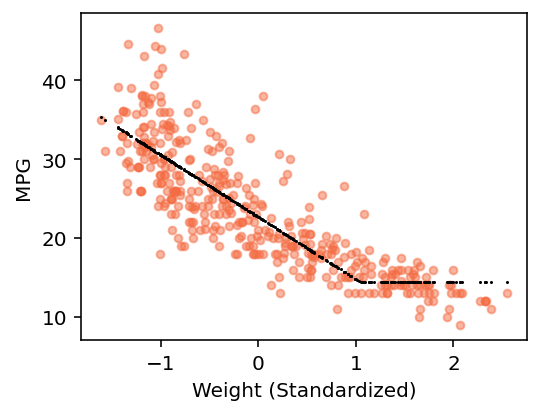

In [125]:
dtype=torch.float
n = len(df_cars)
X = torch.tensor(df_cars.WGT, dtype=dtype).reshape(n,1)
Y = torch.tensor(df_cars.MPG, dtype=dtype).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X), dtype=dtype)

model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),       # add nonlinearity
    nn.Linear(1, 1)
)

learning_rate = 2.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=100
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
# m = model.weight.detach().item()
# b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

with torch.no_grad():
    show(model, X=X, Y=df_cars.MPG)

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      603.792 MAE    23.32
Epoch  200 MSE loss       17.191 MAE     2.97
Epoch  400 MSE loss       16.099 MAE     2.94
Epoch  600 MSE loss       16.147 MAE     2.96
Epoch  800 MSE loss       16.130 MAE     2.96
Epoch 1000 MSE loss       16.121 MAE     2.95
Epoch 1200 MSE loss       16.631 MAE     3.02
Epoch 1400 MSE loss       16.750 MAE     3.11
Epoch 1600 MSE loss       16.413 MAE     3.02
Epoch 1800 MSE loss       16.886 MAE     3.05
Epoch 2000 MSE loss       16.830 MAE     2.97
LAST       MSE loss       16.830 MAE     2.97


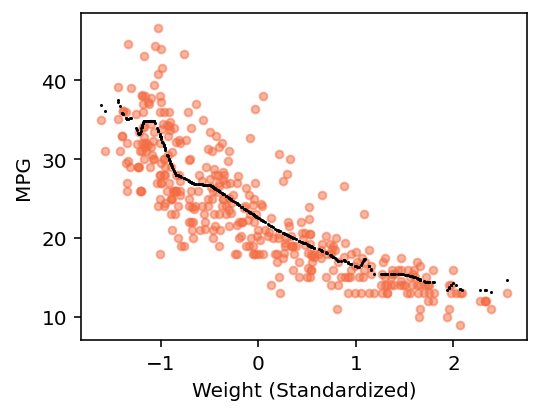

In [159]:
dtype=torch.float
n = len(df_cars)
X = torch.tensor(df_cars.WGT, dtype=dtype).reshape(n,1)
Y = torch.tensor(df_cars.MPG, dtype=dtype).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X), dtype=dtype)

model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # add nonlinearity
    nn.Linear(1000, 1)
)

learning_rate = .5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=2000
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 200 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
# m = model.weight.detach().item()
# b = model.bias.detach().item()
print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")

with torch.no_grad():
    show(model, X=X, Y=df_cars.MPG)